Group Members
- Jonathan Conn
- Matt Boulden
- Arunam Gupta


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import glob

#### Covid Data
Data downloaded from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports_us. This data is about Coronavirus infections in each state in the United States on a daily basis. The code below combines all csv files for each and puts them in a single Pandas dataframe. The second part of this code converts all date and time to datetime objects for better usage.

In [2]:
path = 'covid_data'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

for index, row in frame.iterrows():
    try:
        frame.at[index, "Last_Update"] = datetime.datetime.strptime(frame.at[index, "Last_Update"], '%Y-%m-%d %H:%M:%S')
    except Exception:
        continue
frame

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,Total_Test_Results,Case_Fatality_Ratio
0,Alabama,US,2020-08-07 04:35:29,32.3182,-86.9023,97044,1714,37923.0,56955.0,1.0,1969.984816,739784.0,11313.0,1.774474,84000001.0,USA,15087.825566,11.712150,NaN,NaN
1,Alaska,US,2020-08-07 04:35:29,61.3707,-152.4044,3483,25,1220.0,2238.0,2.0,476.115618,261572.0,NaN,0.717772,84000002.0,USA,35756.105229,NaN,NaN,NaN
2,American Samoa,US,2020-08-07 04:35:29,-14.2710,-170.1320,0,0,NaN,0.0,60.0,0.000000,1396.0,NaN,NaN,16.0,ASM,2508.941248,NaN,NaN,NaN
3,Arizona,US,2020-08-07 04:35:29,33.7298,-111.4312,183656,4002,24531.0,155123.0,4.0,2523.191931,995864.0,14068.0,2.179074,84000004.0,USA,13681.861790,7.659973,NaN,NaN
4,Arkansas,US,2020-08-07 04:35:29,34.9697,-92.3731,47028,515,39555.0,6958.0,5.0,1558.351702,539836.0,3118.0,1.095092,84000005.0,USA,17888.371809,6.630093,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14397,Virginia,US,2020-10-10 04:30:24,37.7693,-78.1700,156649,3344,18336.0,134695.0,51.0,1832.015136,2219510.0,NaN,2.136572,84000051.0,USA,26003.222534,NaN,NaN,NaN
14398,Washington,US,2020-10-10 04:30:24,47.4009,-121.4905,92560,2190,NaN,90370.0,53.0,1215.512812,2016471.0,NaN,2.366033,84000053.0,USA,26480.621592,NaN,NaN,NaN
14399,West Virginia,US,2020-10-10 04:30:24,38.4912,-80.9545,17707,382,12896.0,4429.0,54.0,988.032790,617623.0,NaN,2.157339,84000054.0,USA,34462.742175,NaN,NaN,NaN
14400,Wisconsin,US,2020-10-10 04:30:24,44.2685,-89.6165,144818,1440,115826.0,27552.0,55.0,2487.241590,1671293.0,NaN,0.994352,84000055.0,USA,28704.370028,NaN,NaN,NaN


#### US Economy Baseline
The Dow Jones Industrial Average tracks the 30 largest US companies.  
The S&P 500 tracks the 500 largest US companies and represents 75% of all publicly traded stocks.  
The Nasdaq tracks ~3,000 companies traded on the Nasdaq exchange, while the former two use the NY exchange.  
Together, these market indexes are used to determine how the US economy is performing.

In [77]:
dow_df = pd.read_csv('data/dow_data.csv')
nas_df = pd.read_csv('data/nasdaq_data.csv')
sp_df = pd.read_csv('data/s&p_data.csv')

dow_df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-16,28191.669922,28337.490234,28191.669922,28235.890625,28235.890625,286770000
1,2019-12-17,28221.750000,28328.630859,28220.560547,28267.160156,28267.160156,286770000
2,2019-12-18,28291.439453,28323.250000,28239.279297,28239.279297,28239.279297,289890000
3,2019-12-19,28278.310547,28381.480469,28278.240234,28376.960938,28376.960938,262570000
4,2019-12-20,28608.640625,28608.640625,28445.599609,28455.089844,28455.089844,603780000


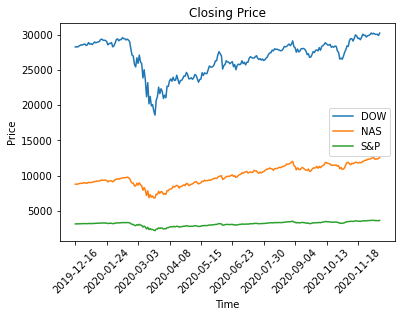

In [78]:
plt.plot(dow_df['Date'], dow_df['Close'], label='DOW')
plt.plot(nas_df['Date'], nas_df['Close'], label='NAS')
plt.plot(sp_df['Date'], sp_df['Close'], label='S&P')

plt.title('Closing Price')
plt.xlabel('Time')
plt.ylabel('Price')

plt.xticks(dow_df['Date'], dow_df['Date'], rotation=45)
plt.locator_params(axis='x', nbins=10)
plt.legend()

plt.show()

#### Standardizing Our Data 
The price points of each index are vastly different.  
To make a good comparison we are going to normalize the data, aggregate it, and visualize it.  
We are going to call this new dataframe our Master and it will represent the US economy.

In [79]:
# seperating price data for each index
price_dow = dow_df[['Open', 'High', 'Low', 'Close']]
price_nas = nas_df[['Open', 'High', 'Low', 'Close']]
price_sp = sp_df[['Open', 'High', 'Low', 'Close']]

# normalizing each index individually
norm_dow = (price_dow - price_dow.mean()) / price_dow.std()
norm_nas = (price_nas - price_nas.mean()) / price_nas.std()
norm_sp = (price_sp - price_sp.mean()) / price_sp.std()

# adding backs correct datetime
norm_dow.insert(loc=0, column='Date', value=dow_df['Date'])
norm_nas.insert(loc=0, column='Date', value=nas_df['Date'])
norm_sp.insert(loc=0, column='Date', value=sp_df['Date'])

norm_dow.head(5)

,Date,Open,High,Low,Close
0,2019-12-16,0.564158,0.555093,0.633392,0.583475
1,2019-12-17,0.576487,0.551317,0.644736,0.596283
2,2019-12-18,0.605051,0.549023,0.652086,0.584863
3,2019-12-19,0.599670,0.573844,0.667385,0.641259
4,2019-12-20,0.735065,0.670674,0.733100,0.673262


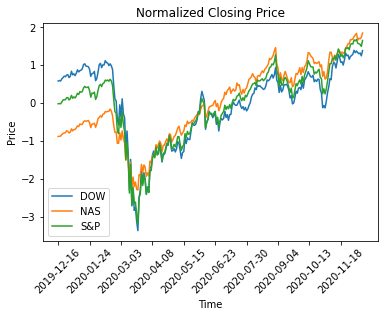

In [80]:
plt.plot(norm_dow['Date'], norm_dow['Close'], label='DOW')
plt.plot(norm_nas['Date'], norm_nas['Close'], label='NAS')
plt.plot(norm_sp['Date'], norm_sp['Close'], label='S&P')

plt.title('Normalized Closing Price')
plt.xlabel('Time')
plt.ylabel('Price')

plt.xticks(norm_dow['Date'], norm_dow['Date'], rotation=45)
plt.locator_params(axis='x', nbins=10)
plt.legend()

plt.show()

In [47]:
# cloning data to modify
label_dow = price_dow
label_nas = price_nas
label_sp = price_sp

# labeling each index correctly for when we aggresgrate them togethers
label_dow.insert(loc=0, column='Index', value='DOW')
label_nas.insert(loc=0, column='Index', value='NAS')
label_sp.insert(loc=0, column='Index', value='S&P')

label_dow.insert(loc=0, column='Date', value=dow_df['Date'])
label_nas.insert(loc=0, column='Date', value=nas_df['Date'])
label_sp.insert(loc=0, column='Date', value=sp_df['Date'])

# creating master dataframe
master_df = pd.concat([label_dow, label_nas, label_sp], ignore_index=True)

# converting dates to correct datatime type, sorting, and reindexing
master_df['Date'] = pd.to_datetime(master_df.Date)
master_df = master_df.sort_values('Date')
master_df = master_df.reset_index(drop=True)

master_df

,Date,Index,Open,High,Low,Close
0,2019-12-16,DOW,28191.669922,28337.490234,28191.669922,28235.890625
1,2019-12-16,NAS,8791.309570,8833.450195,8789.769531,8814.230469
2,2019-12-16,S&P,3183.629883,3197.709961,3183.629883,3191.449951
3,2019-12-17,DOW,28221.750000,28328.630859,28220.560547,28267.160156
4,2019-12-17,NAS,8829.469727,8831.990234,8804.599609,8823.360352
...,...,...,...,...,...,...
754,2020-12-14,DOW,30123.910156,30325.789063,29849.150391,29861.550781
755,2020-12-14,NAS,12447.440430,12543.000000,12432.709961,12440.040039
756,2020-12-15,NAS,12543.259766,12596.129883,12465.419922,12595.059570
757,2020-12-15,DOW,29919.089844,30243.259766,29894.949219,30199.310547


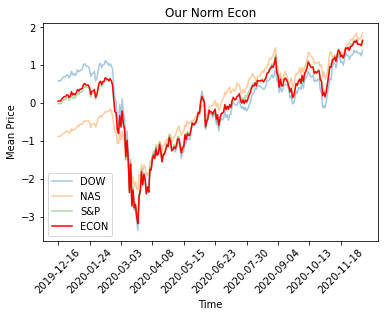

In [92]:
# sum each index for every date and mean normalizing
df = master_df.groupby(master_df.index // 3).sum()
norm_df = (df - df.mean()) / df.std()

# appending dates back for graphing 
norm_df.insert(loc=0, column='Date', value=dow_df['Date'])

plt.plot(norm_dow['Date'], norm_dow['Close'], label='DOW', alpha=0.4)
plt.plot(norm_nas['Date'], norm_nas['Close'], label='NAS', alpha=0.4)
plt.plot(norm_sp['Date'], norm_sp['Close'], label='S&P', alpha=0.4)

plt.plot(norm_df['Date'], norm_df['Close'], color='red', label='ECON')

plt.title('Our Norm Econ')
plt.xlabel('Time')
plt.ylabel('Mean Price')

plt.xticks(norm_df['Date'], norm_df['Date'], rotation=45)
plt.locator_params(axis='x', nbins=10)
plt.legend()
plt.show()